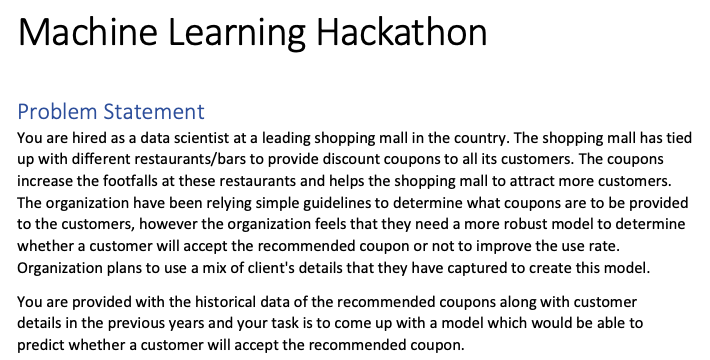

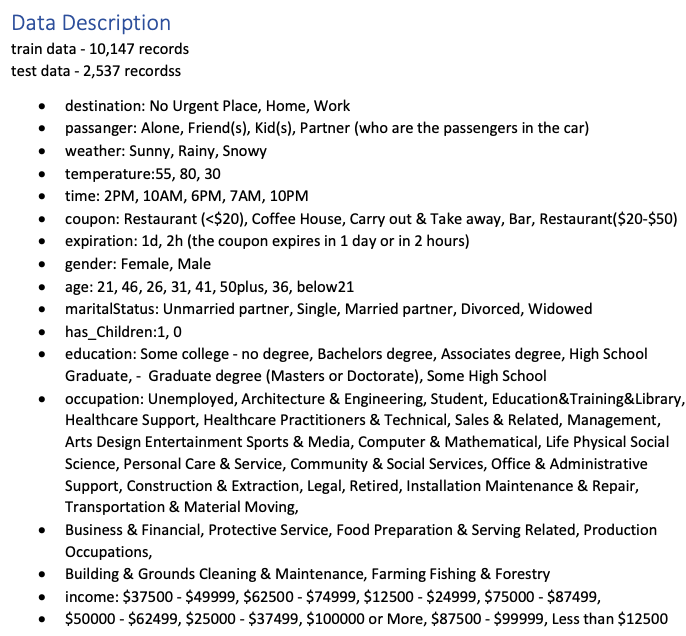

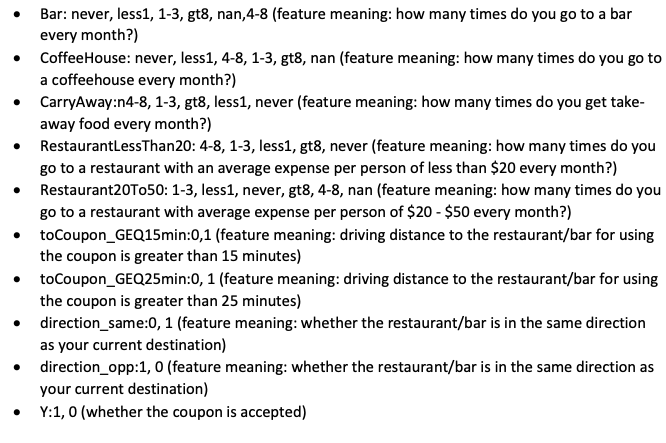

#### Importing required libraries

In [ ]:
#!pip install openpyxl

In [359]:
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.stats import skew

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve,auc


get_ipython().run_line_magic('matplotlib', 'inline')

#### Class for EDA (ExplainatoryDataAnalysis)

In [360]:
class ExplainatoryDataAnalysis:
    def __init__(self, csv_file):
        self.df = pd.read_csv(csv_file)
        self.idColumn = self.df["customer_id"]
    
    def frame(self):
        return self.df
    
    def info(self):
        self.df.info()
        
    def head(self, n):
        return self.df.head(n)
    
    def value_counts(self, columns):
        for col in columns:
            print("Value Counts for ", col)
            print(self.df[col].value_counts())
            print("\n")
    
    def plot_categorical_bivariate(self, feature, i):
        axis = [
            ax[0][0], ax[0][1], ax[0][2], 
            ax[1][0], ax[1][1], ax[1][2]
        ]
        sns.countplot(x=feature, hue='Y', data=self.df, ax=axis[i])
        
    def drop(self, columns, inplace=False):
        self.df.drop(columns=columns, inplace=inplace)
        print("Dropped the columns!")
    
    def hours24(self, x):
        regexampm = "[0-9]+([AM|PM|am|pm]+)"
        regexhour = "([0-9]+)[AM|PM|am|pm]+"
        ampm = re.findall(regexampm, x)[0]
        hour = int(re.findall(regexhour, x)[0])

        if ampm=='PM':
            hour = int(hour)+12
        return hour

    def encode(self, columns, columns_renaming, encode_map):
        index = 0
        for col in columns:
            self.df[columns_renaming[index]] = self.df[col].apply(lambda x: encode_map[x])
            if col!=columns_renaming[index]:
                self.df.drop(columns=[col], inplace=True)
            index = index+1
        print("Encoding done!")
        
    def fill_underscore(self, columns):
        for col in columns:
            self.df[col] = self.df[col].apply(lambda x: re.sub("[\s\-]+", "_", x))
            self.df[col] = self.df[col].apply(lambda x: re.sub("[\(\)]+", "", x))
            self.df[col] = self.df[col].apply(lambda x: re.sub("[\<]+", "lt", x))
            self.df[col] = self.df[col].apply(lambda x: re.sub("[\&]+", "", x))
            self.df[col] = self.df[col].apply(lambda x: re.sub("[\~]+", "_", x))
            print("Space replaced with underscore for column and braces removed", col)
        print("Space replaced with underscore for all columns")
    
    def agemanipulation(self, age):
        correctage = 0
        if age == '50plus':
            correctage = 51
        elif age == 'below21':
            correctage = 20
        else:
            correctage = int(age)
        return correctage

    def income_manipulation(self, x, income_end):
        income = 0
        if x == '$100000 or More':
            x = '$100000 - $0'
        if x =='Less than $12500':
            x = '$0 - $12500'
        incomes = x.split('-')
        incomes[0] = int(re.sub("[\$\s]+", "", incomes[0]))
        incomes[1] = int(re.sub("[\$\s]+", "", incomes[1]))
        if income_end=='min':
            income = incomes[0]
        else:
            income = incomes[1]
        return income
    
    def get_dummies(self, columns, drop_columns):
        category_dummies = pd.get_dummies(self.df[columns])
        self.df.drop(columns=drop_columns, inplace=True)
        self.df = pd.concat([self.df, category_dummies], axis=1)
        print("1. Created dummies for the columns", columns)
        print("2. Dropped columns", drop_columns)
        print("3. Updated data frame with dummy columns")
        return self.head(10)
   
    def corr(self, reference_column, ascending):
        return self.df.corr()[reference_column].sort_values(ascending=ascending)
    
    def feature_scaling(self):
        sc = StandardScaler()
        sc.fit(self.df)
        feature_scaled_arr = sc.transform(self.df)
        self.df = pd.DataFrame(feature_scaled_arr, columns=self.df.columns)
        return self.df
        
    def get_skew(self, column):
        skewDF = {"feature":[column], "skewness":[skew(self.df[column])]}
        return skewDF
    
    def get_skew_df(self):
        skewDF = {"Feature Name":[], "Skewness":[]}
        for col in self.df.columns:
            sd = self.get_skew(col)
            skewDF["Feature Name"].extend(sd['feature'])
            skewDF["Skewness"].extend(sd['skewness'])
        return pd.DataFrame(skewDF)
        
    def select(self, columns):
        return self.df[columns]
    
    def heatmap(self, columns):
        df_selected = pd.DataFrame()
        if len(columns)>0:
            df_selected = self.df[columns]
        else:
            df_selected = self.df
            
        fig, ax = plt.subplots(figsize=(25,10))
        sns.heatmap(df_selected.corr(), cmap="YlGnBu", annot=False, fmt = '.4g', cbar=False, ax=ax)

In [361]:
edai = ExplainatoryDataAnalysis("./datasets/train.csv")

In [362]:
edai.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10147 entries, 0 to 10146
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   customer_id           10147 non-null  int64 
 1   destination           10147 non-null  object
 2   passanger             10147 non-null  object
 3   weather               10147 non-null  object
 4   temperature           10147 non-null  int64 
 5   time                  10147 non-null  object
 6   coupon                10147 non-null  object
 7   expiration            10147 non-null  object
 8   gender                10147 non-null  object
 9   age                   10147 non-null  object
 10  maritalStatus         10147 non-null  object
 11  has_children          10147 non-null  int64 
 12  education             10147 non-null  object
 13  occupation            10147 non-null  object
 14  income                10147 non-null  object
 15  car                   84 non-null   

In [363]:
edai.df.describe()

,customer_id,temperature,has_children,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
count,10147.000000,10147.000000,10147.000000,10147.0,10147.000000,10147.000000,10147.000000,10147.000000,10147.000000
mean,311272.276831,63.172366,0.412634,1.0,0.563024,0.119838,0.212181,0.787819,0.568444
std,106781.701016,19.232595,0.492332,0.0,0.496037,0.324788,0.408872,0.408872,0.495318
min,123472.000000,30.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,221439.000000,55.000000,0.000000,1.0,0.000000,0.000000,0.000000,1.000000,0.000000
50%,310062.000000,80.000000,0.000000,1.0,1.000000,0.000000,0.000000,1.000000,1.000000
75%,401537.000000,80.000000,1.000000,1.0,1.000000,0.000000,0.000000,1.000000,1.000000
max,499988.000000,80.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000


In [364]:
edai.head(12)

,customer_id,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,258868,No Urgent Place,Friend(s),Sunny,80,6PM,Restaurant(<20),1d,Male,21,...,1~3,4~8,4~8,never,1,1,0,0,1,1
1,318369,Work,Alone,Sunny,80,7AM,Restaurant(<20),2h,Male,21,...,1~3,4~8,1~3,less1,1,0,0,1,0,0
2,320906,No Urgent Place,Alone,Sunny,80,10AM,Coffee House,2h,Female,21,...,gt8,4~8,1~3,1~3,1,1,0,0,1,0
3,412393,Work,Alone,Rainy,55,7AM,Restaurant(<20),2h,Female,26,...,less1,4~8,1~3,never,1,1,1,0,1,0
4,290854,Home,Alone,Snowy,30,6PM,Coffee House,1d,Male,31,...,less1,4~8,less1,never,1,1,0,0,1,0
5,438743,Work,Alone,Sunny,80,7AM,Restaurant(20-50),1d,Female,50plus,...,1~3,4~8,4~8,1~3,1,1,0,0,1,1
6,152741,Home,Alone,Sunny,80,6PM,Coffee House,1d,Female,50plus,...,never,4~8,1~3,never,1,0,0,1,0,0
7,268067,No Urgent Place,Alone,Sunny,55,6PM,Coffee House,1d,Female,21,...,1~3,1~3,1~3,less1,1,0,0,0,1,1
8,420352,Home,Alone,Sunny,80,6PM,Restaurant(<20),1d,Male,26,...,1~3,1~3,1~3,1~3,1,0,0,1,0,1
9,425469,No Urgent Place,Friend(s),Sunny,80,10PM,Bar,1d,Female,36,...,less1,1~3,less1,less1,1,1,0,0,1,1


### Graphical inferences

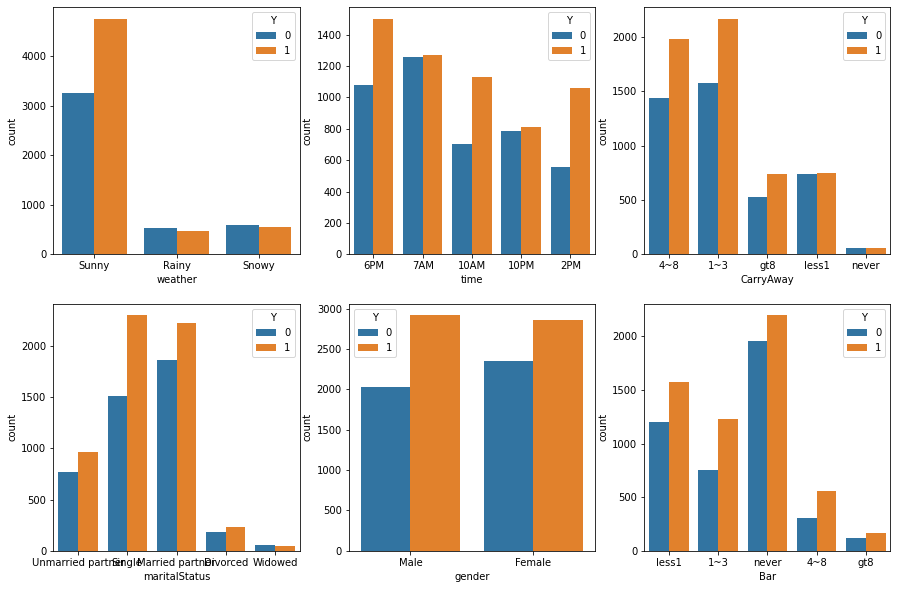

In [365]:
fig, ax = plt.subplots(2,3,figsize=(15,10))
edai.plot_categorical_bivariate("weather",0)
edai.plot_categorical_bivariate("time",1)
edai.plot_categorical_bivariate("CarryAway",2)
edai.plot_categorical_bivariate("maritalStatus",3)
edai.plot_categorical_bivariate("gender",4)
edai.plot_categorical_bivariate("Bar",5)

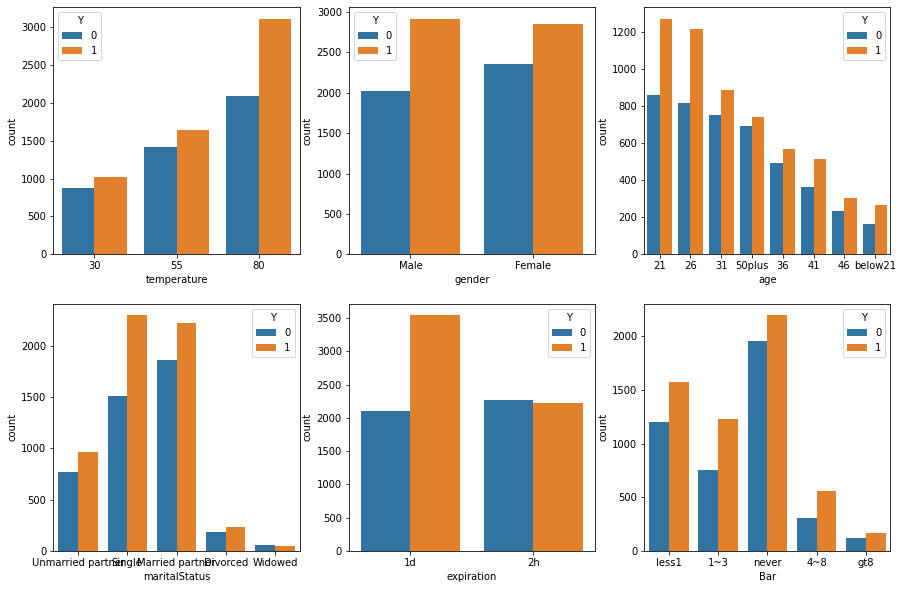

In [366]:
fig, ax = plt.subplots(2,3,figsize=(15,10))
edai.plot_categorical_bivariate("temperature",0)
edai.plot_categorical_bivariate("gender",1)
edai.plot_categorical_bivariate("age",2)
edai.plot_categorical_bivariate("maritalStatus",3)
edai.plot_categorical_bivariate("expiration",4)
edai.plot_categorical_bivariate("Bar",5)

<AxesSubplot:xlabel='income', ylabel='count'>

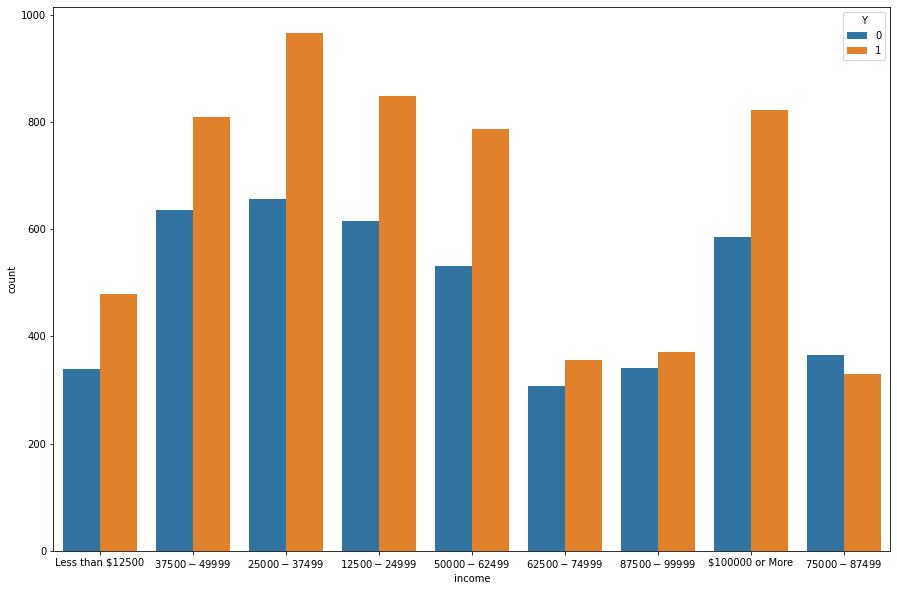

In [367]:
fig, ax = plt.subplots(figsize=(15,10))
sns.countplot(x="income", hue='Y', data=edai.df)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 [Text(0, 0, 'Student'),
  Text(1, 0, 'Computer & Mathematical'),
  Text(2, 0, 'Unemployed'),
  Text(3, 0, 'Healthcare Support'),
  Text(4, 0, 'Retired'),
  Text(5, 0, 'Food Preparation & Serving Related'),
  Text(6, 0, 'Sales & Related'),
  Text(7, 0, 'Architecture & Engineering'),
  Text(8, 0, 'Education&Training&Library'),
  Text(9, 0, 'Arts Design Entertainment Sports & Media'),
  Text(10, 0, 'Management'),
  Text(11, 0, 'Community & Social Services'),
  Text(12, 0, 'Life Physical Social Science'),
  Text(13, 0, 'Transportation & Material Moving'),
  Text(14, 0, 'Farming Fishing & Forestry'),
  Text(15, 0, 'Business & Financial'),
  Text(16, 0, 'Office & Administrative Support'),
  Text(17, 0, 'Legal'),
  Text(18, 0, 'Personal Care & Service'),
  Text(19, 0, 'Healthcare Practitioners & Technical'),
  Text(20, 0, 'Protective Service'),
  Text(21, 0, 'Building & Groun

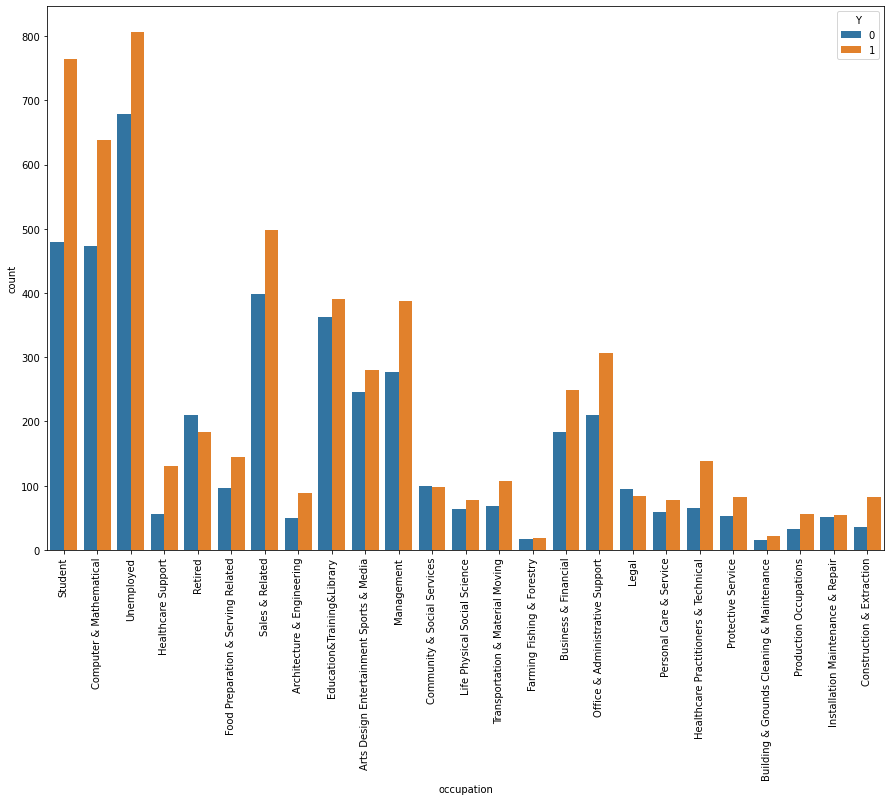

In [368]:
fig, ax = plt.subplots(figsize=(15,10))
sns.countplot(x="occupation",hue='Y',data=edai.df)
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Some college - no degree'),
  Text(1, 0, 'Bachelors degree'),
  Text(2, 0, 'Graduate degree (Masters or Doctorate)'),
  Text(3, 0, 'Associates degree'),
  Text(4, 0, 'High School Graduate'),
  Text(5, 0, 'Some High School')])

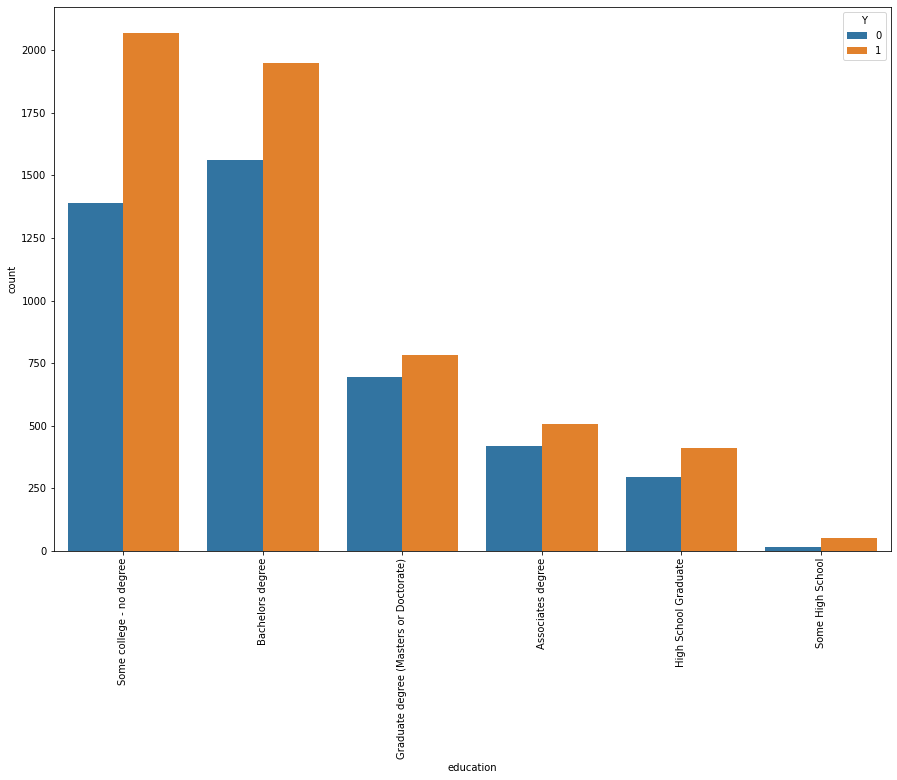

In [369]:
fig, ax = plt.subplots(figsize=(15,10))
sns.countplot(x="education",hue='Y',data=edai.df)
plt.xticks(rotation=90)

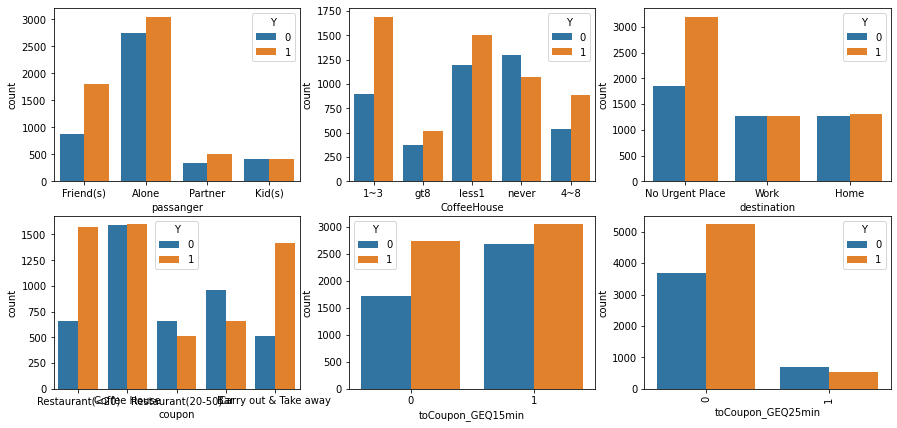

In [370]:
fig, ax = plt.subplots(2,3,figsize=(15,7))
plt.xticks(rotation=90)
edai.plot_categorical_bivariate("passanger",0)
edai.plot_categorical_bivariate("CoffeeHouse",1)
edai.plot_categorical_bivariate("destination",2)
edai.plot_categorical_bivariate("coupon",3)
edai.plot_categorical_bivariate("toCoupon_GEQ15min",4)
edai.plot_categorical_bivariate("toCoupon_GEQ25min",5)

In [371]:
edai.df.columns

Index(['customer_id', 'destination', 'passanger', 'weather', 'temperature',
       'time', 'coupon', 'expiration', 'gender', 'age', 'maritalStatus',
       'has_children', 'education', 'occupation', 'income', 'car', 'Bar',
       'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50',
       'toCoupon_GEQ5min', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min',
       'direction_same', 'direction_opp', 'Y'],
      dtype='object')

In [372]:
edai.value_counts(columns=['destination', 'passanger', 'weather', 'temperature',
       'time', 'coupon', 'expiration', 'gender', 'age', 'maritalStatus',
       'has_children', 'education', 'occupation', 'income', 'car', 'Bar',
       'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50',
       'toCoupon_GEQ5min', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min',
       'direction_same', 'direction_opp'])

Value Counts for  destination
No Urgent Place    5045
Home               2572
Work               2530
Name: destination, dtype: int64


Value Counts for  passanger
Alone        5802
Friend(s)    2676
Partner       855
Kid(s)        814
Name: passanger, dtype: int64


Value Counts for  weather
Sunny    8015
Snowy    1142
Rainy     990
Name: weather, dtype: int64


Value Counts for  temperature
80    5203
55    3058
30    1886
Name: temperature, dtype: int64


Value Counts for  time
6PM     2576
7AM     2530
10AM    1833
2PM     1616
10PM    1592
Name: time, dtype: int64


Value Counts for  coupon
Coffee House             3191
Restaurant(<20)          2233
Carry out & Take away    1923
Bar                      1623
Restaurant(20-50)        1177
Name: coupon, dtype: int64


Value Counts for  expiration
1d    5643
2h    4504
Name: expiration, dtype: int64


Value Counts for  gender
Female    5204
Male      4943
Name: gender, dtype: int64


Value Counts for  age
21         2133
26         2

#### Based on the above analysis we can conclude floowing points:

- Total 10147 entries available.

- There are only 8 numerical features customer_id, temperature, has_children, toCoupon_GEQ5min, toCoupon_GEQ15min, toCoupon_GEQ25min, direction_same, direction_opp, Y

- customer_id, toCoupon_GEQ5min can be removed as they all have same values

- Following columns need missing values treatments:
    - car (84 non-null object), 
    - Bar (10059 non-null object), 
    - CoffeeHouse (9975 non-null object), 
    - CarryAway (10025 non-null object), 
    - RestaurantLessThan20 (10050 non-null object), 
    - Restaurant20To50 (9999 non-null object)
    
- Following approach to be taken to fill the missing values:
    - car (84 non-null object): Can be removed, mostly null vaues  
    - Bar (10059 non-null object): filling with the ffill  
    - CoffeeHouse (9975 non-null object): filling with ffill 
    - CarryAway (10025 non-null object): filling with ffill 
    - RestaurantLessThan20 (10050 non-null object): filling with ffill  
    - Restaurant20To50 (9999 non-null object): filling with ffill

In [373]:
edai.drop(columns=["customer_id", "toCoupon_GEQ5min", "car"], inplace=True)

Dropped the columns!


In [374]:
edai.df["Bar"].fillna(method='ffill',inplace=True)
edai.df["CoffeeHouse"].fillna(method='ffill',inplace=True)
edai.df["CarryAway"].fillna(method='ffill',inplace=True)
edai.df["RestaurantLessThan20"].fillna(method='ffill',inplace=True)
edai.df["Restaurant20To50"].fillna(method='ffill',inplace=True)

In [375]:
edai.value_counts(columns=['destination', 'passanger', 'weather', 'temperature',
       'time', 'coupon', 'expiration', 'gender', 'age', 'maritalStatus',
       'has_children', 'education', 'occupation', 'income', 'Bar',
       'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min',
       'direction_same', 'direction_opp'])

Value Counts for  destination
No Urgent Place    5045
Home               2572
Work               2530
Name: destination, dtype: int64


Value Counts for  passanger
Alone        5802
Friend(s)    2676
Partner       855
Kid(s)        814
Name: passanger, dtype: int64


Value Counts for  weather
Sunny    8015
Snowy    1142
Rainy     990
Name: weather, dtype: int64


Value Counts for  temperature
80    5203
55    3058
30    1886
Name: temperature, dtype: int64


Value Counts for  time
6PM     2576
7AM     2530
10AM    1833
2PM     1616
10PM    1592
Name: time, dtype: int64


Value Counts for  coupon
Coffee House             3191
Restaurant(<20)          2233
Carry out & Take away    1923
Bar                      1623
Restaurant(20-50)        1177
Name: coupon, dtype: int64


Value Counts for  expiration
1d    5643
2h    4504
Name: expiration, dtype: int64


Value Counts for  gender
Female    5204
Male      4943
Name: gender, dtype: int64


Value Counts for  age
21         2133
26         2

- destination, passanger, coupon, occupation, education, maritalStatus, Bar, CoffeeHouse, CarryAway, RestaurantLessThan20, Restaurant20To50 need cleaning

In [376]:
edai.fill_underscore(columns=["destination", "passanger", "coupon", "occupation", "education", "maritalStatus", "Bar", "CoffeeHouse", "CarryAway", "RestaurantLessThan20", "Restaurant20To50"])

Space replaced with underscore for column and braces removed destination
Space replaced with underscore for column and braces removed passanger
Space replaced with underscore for column and braces removed coupon
Space replaced with underscore for column and braces removed occupation
Space replaced with underscore for column and braces removed education
Space replaced with underscore for column and braces removed maritalStatus
Space replaced with underscore for column and braces removed Bar
Space replaced with underscore for column and braces removed CoffeeHouse
Space replaced with underscore for column and braces removed CarryAway
Space replaced with underscore for column and braces removed RestaurantLessThan20
Space replaced with underscore for column and braces removed Restaurant20To50
Space replaced with underscore for all columns


In [377]:
edai.value_counts(columns=['destination', 'passanger', 'weather', 'temperature',
       'time', 'coupon', 'expiration', 'gender', 'age', 'maritalStatus',
       'has_children', 'education', 'occupation', 'income', 'Bar',
       'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50',
       'toCoupon_GEQ15min', 'toCoupon_GEQ25min',
       'direction_same', 'direction_opp'])

Value Counts for  destination
No_Urgent_Place    5045
Home               2572
Work               2530
Name: destination, dtype: int64


Value Counts for  passanger
Alone      5802
Friends    2676
Partner     855
Kids        814
Name: passanger, dtype: int64


Value Counts for  weather
Sunny    8015
Snowy    1142
Rainy     990
Name: weather, dtype: int64


Value Counts for  temperature
80    5203
55    3058
30    1886
Name: temperature, dtype: int64


Value Counts for  time
6PM     2576
7AM     2530
10AM    1833
2PM     1616
10PM    1592
Name: time, dtype: int64


Value Counts for  coupon
Coffee_House            3191
Restaurantlt20          2233
Carry_out__Take_away    1923
Bar                     1623
Restaurant20_50         1177
Name: coupon, dtype: int64


Value Counts for  expiration
1d    5643
2h    4504
Name: expiration, dtype: int64


Value Counts for  gender
Female    5204
Male      4943
Name: gender, dtype: int64


Value Counts for  age
21         2133
26         2033
31       

- time 6PM to 24 hours
- expiration 1d, 2h to hours format
- age 50plus, below21 to 51 and 20
- income, remove \$, min_income and max_income.
- income, or more should have 0 in max_income
- income, Less than should be 0 in min_income

In [378]:
edai.df["time"] = edai.df["time"].apply(edai.hours24)

In [379]:
edai.df["time"].value_counts()

18    2576
7     2530
10    1833
14    1616
22    1592
Name: time, dtype: int64

In [380]:
toHours = {'1d':24,'2h':2}
edai.df["expiration"] = edai.df["expiration"].apply(lambda x: toHours[x])

In [381]:
edai.df["expiration"].value_counts()

24    5643
2     4504
Name: expiration, dtype: int64

In [382]:
edai.df["age"] = edai.df["age"].apply(edai.agemanipulation)

In [383]:
edai.df["income_min"] = edai.df["income"].apply(edai.income_manipulation, income_end='min')
edai.df["income_max"] = edai.df["income"].apply(edai.income_manipulation, income_end='max')

In [384]:
edai.df["age"].value_counts()

21    2133
26    2033
31    1636
51    1431
36    1065
41     879
46     538
20     432
Name: age, dtype: int64

In [385]:
edai.df.drop(columns=["income"], inplace=True)

In [386]:
edai.value_counts(columns=['destination', 'passanger', 'weather', 'temperature',
       'time', 'coupon', 'expiration', 'gender', 'age', 'maritalStatus',
       'has_children', 'education', 'occupation', 'income_min', 'income_max', 'Bar',
       'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50',
       'toCoupon_GEQ15min', 'toCoupon_GEQ25min',
       'direction_same', 'direction_opp'])

Value Counts for  destination
No_Urgent_Place    5045
Home               2572
Work               2530
Name: destination, dtype: int64


Value Counts for  passanger
Alone      5802
Friends    2676
Partner     855
Kids        814
Name: passanger, dtype: int64


Value Counts for  weather
Sunny    8015
Snowy    1142
Rainy     990
Name: weather, dtype: int64


Value Counts for  temperature
80    5203
55    3058
30    1886
Name: temperature, dtype: int64


Value Counts for  time
18    2576
7     2530
10    1833
14    1616
22    1592
Name: time, dtype: int64


Value Counts for  coupon
Coffee_House            3191
Restaurantlt20          2233
Carry_out__Take_away    1923
Bar                     1623
Restaurant20_50         1177
Name: coupon, dtype: int64


Value Counts for  expiration
24    5643
2     4504
Name: expiration, dtype: int64


Value Counts for  gender
Female    5204
Male      4943
Name: gender, dtype: int64


Value Counts for  age
21    2133
26    2033
31    1636
51    1431
36    1

In [387]:
edai.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10147 entries, 0 to 10146
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           10147 non-null  object
 1   passanger             10147 non-null  object
 2   weather               10147 non-null  object
 3   temperature           10147 non-null  int64 
 4   time                  10147 non-null  int64 
 5   coupon                10147 non-null  object
 6   expiration            10147 non-null  int64 
 7   gender                10147 non-null  object
 8   age                   10147 non-null  int64 
 9   maritalStatus         10147 non-null  object
 10  has_children          10147 non-null  int64 
 11  education             10147 non-null  object
 12  occupation            10147 non-null  object
 13  Bar                   10147 non-null  object
 14  CoffeeHouse           10147 non-null  object
 15  CarryAway             10147 non-null

- features eligible for dummies are destination, passanger, weather, coupon, gender, maritalStatus, education,
occupation, Bar, CoffeeHouse, CarryAway, RestaurantLessThan20, Restaurant20To50, 

- in this we still will remove Female after encoding

In [388]:
dummies = pd.get_dummies(edai.df[["destination", "passanger", "weather", "coupon", "gender", "maritalStatus",
                            "education", "occupation", "Bar", "CoffeeHouse", "CarryAway", "RestaurantLessThan20", "Restaurant20To50"]])

In [389]:
dummies.drop(columns=["gender_Female"], inplace=True)

In [390]:
dummies.columns

Index(['destination_Home', 'destination_No_Urgent_Place', 'destination_Work',
       'passanger_Alone', 'passanger_Friends', 'passanger_Kids',
       'passanger_Partner', 'weather_Rainy', 'weather_Snowy', 'weather_Sunny',
       'coupon_Bar', 'coupon_Carry_out__Take_away', 'coupon_Coffee_House',
       'coupon_Restaurant20_50', 'coupon_Restaurantlt20', 'gender_Male',
       'maritalStatus_Divorced', 'maritalStatus_Married_partner',
       'maritalStatus_Single', 'maritalStatus_Unmarried_partner',
       'maritalStatus_Widowed', 'education_Associates_degree',
       'education_Bachelors_degree',
       'education_Graduate_degree_Masters_or_Doctorate',
       'education_High_School_Graduate', 'education_Some_High_School',
       'education_Some_college_no_degree',
       'occupation_Architecture__Engineering',
       'occupation_Arts_Design_Entertainment_Sports__Media',
       'occupation_Building__Grounds_Cleaning__Maintenance',
       'occupation_Business__Financial',
       'occupatio

In [391]:
edai.df.drop(columns=["destination", "passanger", "weather", "coupon", "gender", "maritalStatus",
                            "education", "occupation", "Bar", "CoffeeHouse", "CarryAway", "RestaurantLessThan20", "Restaurant20To50"], inplace=True)

In [392]:
edai.df

,temperature,time,expiration,age,has_children,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y,income_min,income_max
0,80,18,24,21,0,1,0,0,1,1,0,12500
1,80,7,2,21,0,0,0,1,0,0,37500,49999
2,80,10,2,21,0,1,0,0,1,0,0,12500
3,55,7,2,26,0,1,1,0,1,0,25000,37499
4,30,18,24,31,0,1,0,0,1,0,12500,24999
...,...,...,...,...,...,...,...,...,...,...,...,...
10142,80,18,2,20,0,1,0,1,0,0,0,12500
10143,80,18,24,26,0,0,0,1,0,1,37500,49999
10144,80,10,2,21,0,0,0,0,1,1,25000,37499
10145,30,22,2,46,1,0,0,0,1,0,100000,0


In [393]:
edai.df = pd.concat([edai.df, dummies], axis=1)

In [394]:
len(edai.df.columns)

89

- Feature scaling is not used as the Tree model is target .

In [395]:
#edai.feature_scaling()

In [396]:
len(edai.df)

10147

In [397]:
cor = edai.df.corr()["Y"].sort_values(ascending=False)

In [398]:
cor.head(20)

Y                                                 1.000000
coupon_Carry_out__Take_away                       0.162912
coupon_Restaurantlt20                             0.146805
expiration                                        0.133069
destination_No_Urgent_Place                       0.131406
passanger_Friends                                 0.125912
weather_Sunny                                     0.098134
CoffeeHouse_1_3                                   0.097343
maritalStatus_Single                              0.054456
temperature                                       0.053147
Bar_1_3                                           0.051750
Bar_4_8                                           0.046663
CoffeeHouse_4_8                                   0.045890
education_Some_college_no_degree                  0.043133
gender_Male                                       0.041871
Restaurant20To50_4_8                              0.041369
occupation_Healthcare_Support                     0.0359

In [399]:
cor.tail(20)

Restaurant20To50_never          -0.035691
passanger_Kids                  -0.039346
maritalStatus_Married_partner   -0.040028
has_children                    -0.040851
occupation_Retired              -0.041164
income_max                      -0.045708
age                             -0.051105
CarryAway_less1                 -0.052814
weather_Snowy                   -0.064951
weather_Rainy                   -0.065554
Bar_never                       -0.067526
destination_Home                -0.074576
destination_Work                -0.076882
toCoupon_GEQ15min               -0.081642
coupon_Coffee_House             -0.091667
coupon_Restaurant20_50          -0.095728
toCoupon_GEQ25min               -0.098778
passanger_Alone                 -0.100172
CoffeeHouse_never               -0.127925
coupon_Bar                      -0.140365
Name: Y, dtype: float64

### Saving the skewness in a file

In [400]:
edai.get_skew_df().to_excel("skewness.xlsx")

### Creating the clean_train.csv data file to further use in modeling

In [401]:
edai.df.to_csv("clean_train.csv")

## Consolidated Cleaning Steps (Cleaning the test data)

In [402]:
edait = ExplainatoryDataAnalysis("./datasets/test.csv")

In [403]:
edait.drop(columns=["customer_id", "toCoupon_GEQ5min", "car"], inplace=True)

Dropped the columns!


In [404]:
edait.df["Bar"].fillna(method='ffill',inplace=True)

In [405]:
edait.df["CoffeeHouse"].fillna(method='ffill',inplace=True)

In [406]:
edait.df["CarryAway"].fillna(method='ffill',inplace=True)

In [407]:
edait.df["RestaurantLessThan20"].fillna(method='ffill',inplace=True)

In [408]:
edait.df["Restaurant20To50"].fillna(method='ffill',inplace=True)

In [409]:
edait.fill_underscore(columns=["destination", "passanger", "coupon", "occupation", "education", "maritalStatus", "Bar", "CoffeeHouse", "CarryAway", "RestaurantLessThan20", "Restaurant20To50"])

Space replaced with underscore for column and braces removed destination
Space replaced with underscore for column and braces removed passanger
Space replaced with underscore for column and braces removed coupon
Space replaced with underscore for column and braces removed occupation
Space replaced with underscore for column and braces removed education
Space replaced with underscore for column and braces removed maritalStatus
Space replaced with underscore for column and braces removed Bar
Space replaced with underscore for column and braces removed CoffeeHouse
Space replaced with underscore for column and braces removed CarryAway
Space replaced with underscore for column and braces removed RestaurantLessThan20
Space replaced with underscore for column and braces removed Restaurant20To50
Space replaced with underscore for all columns


In [410]:
edait.df["time"] = edait.df["time"].apply(edait.hours24)

In [411]:
toHours = {'1d':24,'2h':2}
edait.df["expiration"] = edait.df["expiration"].apply(lambda x: toHours[x])

In [412]:
edait.df["age"] = edait.df["age"].apply(edait.agemanipulation)

In [413]:
edait.df["income_min"] = edait.df["income"].apply(edait.income_manipulation, income_end='min')
edait.df["income_max"] = edait.df["income"].apply(edait.income_manipulation, income_end='max')

In [414]:
edait.df.drop(columns=["income"], inplace=True)

In [415]:
dummies2 = pd.get_dummies(edait.df[["destination", "passanger", "weather", "coupon", "gender", "maritalStatus",
                            "education", "occupation", "Bar", "CoffeeHouse", "CarryAway", "RestaurantLessThan20", "Restaurant20To50"]])

In [416]:
dummies2.drop(columns=["gender_Female"], inplace=True)

In [417]:
edait.df.drop(columns=["destination", "passanger", "weather", "coupon", "gender", "maritalStatus",
                            "education", "occupation", "Bar", "CoffeeHouse", "CarryAway", "RestaurantLessThan20", "Restaurant20To50"], inplace=True)

In [418]:
edait.df = pd.concat([edait.df, dummies2], axis=1)

In [419]:
edait.df.to_csv("final_clean_test.csv")

In [420]:
fedait = pd.read_csv("final_clean_test.csv")

In [421]:
fedait.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2537 entries, 0 to 2536
Data columns (total 89 columns):
 #   Column                                              Non-Null Count  Dtype
---  ------                                              --------------  -----
 0   Unnamed: 0                                          2537 non-null   int64
 1   temperature                                         2537 non-null   int64
 2   time                                                2537 non-null   int64
 3   expiration                                          2537 non-null   int64
 4   age                                                 2537 non-null   int64
 5   has_children                                        2537 non-null   int64
 6   toCoupon_GEQ15min                                   2537 non-null   int64
 7   toCoupon_GEQ25min                                   2537 non-null   int64
 8   direction_same                                      2537 non-null   int64
 9   direction_opp      

### The cleaned data at clean_train.csv as extracted in the above lines will be further used for modeling

In [422]:
df_train = pd.read_csv('clean_train.csv')
df_train.drop('Unnamed: 0',axis=1,inplace=True)
df_train.head()

,temperature,time,expiration,age,has_children,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y,...,RestaurantLessThan20_1_3,RestaurantLessThan20_4_8,RestaurantLessThan20_gt8,RestaurantLessThan20_less1,RestaurantLessThan20_never,Restaurant20To50_1_3,Restaurant20To50_4_8,Restaurant20To50_gt8,Restaurant20To50_less1,Restaurant20To50_never
0,80,18,24,21,0,1,0,0,1,1,...,0,1,0,0,0,0,0,0,0,1
1,80,7,2,21,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
2,80,10,2,21,0,1,0,0,1,0,...,1,0,0,0,0,1,0,0,0,0
3,55,7,2,26,0,1,1,0,1,0,...,1,0,0,0,0,0,0,0,0,1
4,30,18,24,31,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1


# Implementing the ML part:

In [423]:
# Seperating the feature & traget:
X = df_train.drop('Y',axis=1).copy()
y = df_train['Y']

In [424]:
X.head()

,temperature,time,expiration,age,has_children,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,income_min,...,RestaurantLessThan20_1_3,RestaurantLessThan20_4_8,RestaurantLessThan20_gt8,RestaurantLessThan20_less1,RestaurantLessThan20_never,Restaurant20To50_1_3,Restaurant20To50_4_8,Restaurant20To50_gt8,Restaurant20To50_less1,Restaurant20To50_never
0,80,18,24,21,0,1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
1,80,7,2,21,0,0,0,1,0,37500,...,1,0,0,0,0,0,0,0,1,0
2,80,10,2,21,0,1,0,0,1,0,...,1,0,0,0,0,1,0,0,0,0
3,55,7,2,26,0,1,1,0,1,25000,...,1,0,0,0,0,0,0,0,0,1
4,30,18,24,31,0,1,0,0,1,12500,...,0,0,0,1,0,0,0,0,0,1


### Decision Tree :

### Trial 1

In [425]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25,stratify=y) # not used stratify

In [426]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((8117, 88), (2030, 88), (8117,), (2030,))

- **Now we will be fitting the Decision Tree model on the training dataset**

In [427]:
from sklearn.model_selection import GridSearchCV
dct = DecisionTreeClassifier(random_state=80)
params = {'max_depth':list(range(1,11)), 'criterion':['gini', 'entropy']}   # 'max_depth' it can be taken any range.
cv_model = GridSearchCV(dct, param_grid = params)
cv_model.fit(X_train,y_train)
print(cv_model.best_params_)

{'criterion': 'entropy', 'max_depth': 6}


In [428]:
dct = DecisionTreeClassifier(max_depth=6, criterion='entropy')
dct.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=6)

In [429]:
y_pred = dct.predict(X_test)

In [430]:
round(accuracy_score(y_test,y_pred),2)

0.68

In [431]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[478, 398],
       [242, 912]])

In [432]:
f1_score(y_test,y_pred)

0.7402597402597402

In [433]:
prob = dct.predict_proba(X_test)
prob

array([[0.78717201, 0.21282799],
       [0.25757576, 0.74242424],
       [0.69767442, 0.30232558],
       ...,
       [0.27350427, 0.72649573],
       [0.        , 1.        ],
       [0.17006803, 0.82993197]])

In [434]:
prob_positive = prob[:,1]

In [435]:
fpr, tpr, threshold = roc_curve(y_test,prob_positive)

In [436]:
ftt = pd.DataFrame(np.hstack((threshold.reshape(-1,1),fpr.reshape(-1,1),tpr.reshape(-1,1))),columns = ['threshold','fpr','tpr'])
ftt.head()

,threshold,fpr,tpr
0,2.000000,0.000000,0.000000
1,1.000000,0.006849,0.023397
2,0.976744,0.011416,0.032929
3,0.880000,0.012557,0.038128
4,0.862992,0.035388,0.166378


In [437]:
roc_auc = auc(fpr,tpr)
roc_auc

0.7254848135925865

In [438]:
def plot_ROC(roc,fpr,tpr):
    plt.title("receiver Operating Charecteristc")
    plt.plot(fpr,tpr,'red',label = 'AUC=%0.2f'% roc)
    plt.legend(loc = 'lower right')
    plt.plot([0,1],[0,1], color = 'darkblue',linestyle='--')
    plt.ylabel('True positive Rate')
    plt.xlabel('False positive Rate')
    plt.show()

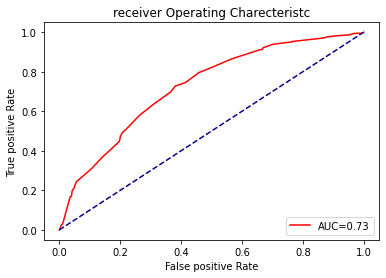

In [439]:
plot_ROC(roc_auc,fpr,tpr)

### Trial 2

In [440]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) # not used stratify & random state

In [441]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((8117, 88), (2030, 88), (8117,), (2030,))

In [442]:
dct2 = DecisionTreeClassifier(random_state=80)
params = {'max_depth':list(range(1,11)), 'criterion':['gini', 'entropy']}   # 'max_depth' it can be taken any range.
cv_model = GridSearchCV(dct2, param_grid = params)
cv_model.fit(X_train,y_train)
print(cv_model.best_params_)

{'criterion': 'gini', 'max_depth': 8}


In [443]:
dct2 = DecisionTreeClassifier(criterion='entropy',max_depth=9)
dct2.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=9)

In [444]:
y_pred = dct2.predict(X_test)

In [445]:
round(accuracy_score(y_test,y_pred),2)

0.71

In [446]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[497, 359],
       [232, 942]])

In [447]:
f1_score(y_test,y_pred)

0.7612121212121212

In [448]:
prob = dct.predict_proba(X_test)
prob

array([[0.13700787, 0.86299213],
       [0.54873646, 0.45126354],
       [0.37254902, 0.62745098],
       ...,
       [0.78717201, 0.21282799],
       [0.33333333, 0.66666667],
       [0.41509434, 0.58490566]])

In [449]:
prob_positive = prob[:,1]

In [450]:
fpr, tpr, threshold = roc_curve(y_test,prob_positive)

In [451]:
ftt = pd.DataFrame(np.hstack((threshold.reshape(-1,1),fpr.reshape(-1,1),tpr.reshape(-1,1))),columns = ['threshold','fpr','tpr'])
ftt

,threshold,fpr,tpr
0,2.000000,0.000000,0.000000
1,1.000000,0.000000,0.028961
2,0.976744,0.001168,0.039182
3,0.880000,0.004673,0.047700
4,0.862992,0.030374,0.160136
5,0.857143,0.031542,0.167802
6,0.842857,0.036215,0.202726
7,0.829932,0.042056,0.222317
8,0.814815,0.043224,0.228279
9,0.775701,0.047897,0.250426


In [452]:
roc_auc = auc(fpr,tpr)
roc_auc

0.7624081540861978

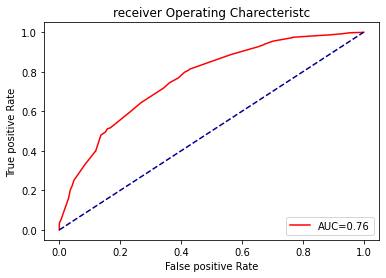

In [453]:
plot_ROC(roc_auc,fpr,tpr)

### Trial 3:

In [454]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1) # not used stratify

In [455]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((9132, 88), (1015, 88), (9132,), (1015,))

In [456]:
dct3 = DecisionTreeClassifier(random_state=80)
params = {'max_depth':list(range(1,11)), 'criterion':['gini', 'entropy']}   # 'max_depth' it can be taken any range.
cv_model = GridSearchCV(dct3, param_grid = params)
cv_model.fit(X_train,y_train)
print(cv_model.best_params_)

{'criterion': 'gini', 'max_depth': 8}


In [457]:
dct3 = DecisionTreeClassifier(max_depth=8, criterion='entropy')
dct3.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=8)

In [458]:
y_pred = dct.predict(X_test)

In [459]:
round(accuracy_score(y_test,y_pred),2)

0.7

## Random Forest :

### Trial 1:

In [460]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25,stratify=y) # not used stratify

In [461]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((8117, 88), (2030, 88), (8117,), (2030,))

In [462]:
rfc = RandomForestClassifier()
params = {'n_estimators':list(range(1,20))}   # 'max_depth' it can be taken any range.
cv_model = GridSearchCV(estimator=rfc, cv=5, param_grid = params)
cv_model.fit(X_train,y_train)
print(cv_model.best_params_)

{'n_estimators': 18}


In [463]:
rfc = RandomForestClassifier(n_estimators=19, max_depth=3, random_state=1)

In [464]:
rfc.fit(X_train,y_train)

RandomForestClassifier(max_depth=3, n_estimators=19, random_state=1)

In [465]:
y_pred = rfc.predict(X_test)

In [466]:
round(accuracy_score(y_test,y_pred),2)

0.65

### Trial 2:

In [467]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15) # not used stratify

In [468]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((8624, 88), (1523, 88), (8624,), (1523,))

In [469]:
rfc = RandomForestClassifier()
params = {'n_estimators':list(range(1,89))}   # 'max_depth' it can be taken any range.
cv_model = GridSearchCV(estimator=rfc,cv=5,param_grid = params,return_train_score=True)
cv_model.fit(X_train,y_train)
print(cv_model.best_params_)

{'n_estimators': 85}


In [470]:
rfc = RandomForestClassifier(n_estimators=86,min_samples_split=4)

In [471]:
rfc.fit(X_train,y_train)

RandomForestClassifier(min_samples_split=4, n_estimators=86)

In [472]:
y_pred=rfc.predict(X_test)

In [473]:
accuracy_score(y_test,y_pred)

0.7314510833880499

In [474]:
prob = rfc.predict_proba(X_test)
prob

array([[0.52693798, 0.47306202],
       [0.19665006, 0.80334994],
       [0.45556478, 0.54443522],
       ...,
       [0.22549834, 0.77450166],
       [0.26046512, 0.73953488],
       [0.35077519, 0.64922481]])

In [475]:
prob_positive = prob[:,1]

In [476]:
fpr, tpr, threshold = roc_curve(y_test,prob_positive)

In [477]:
ftt = pd.DataFrame(np.hstack((threshold.reshape(-1,1),fpr.reshape(-1,1),tpr.reshape(-1,1))),columns = ['threshold','fpr','tpr'])
ftt[:150]

,threshold,fpr,tpr
0,1.962791,0.000000,0.000000
1,0.962791,0.000000,0.001140
2,0.954845,0.000000,0.003421
3,0.953654,0.001548,0.003421
4,0.943798,0.001548,0.009122
...,...,...,...
145,0.686822,0.119195,0.524515
146,0.686489,0.120743,0.524515
147,0.686047,0.120743,0.525656
148,0.685853,0.122291,0.525656


In [478]:
roc_auc = auc(fpr,tpr)
roc_auc

0.8053860084512711

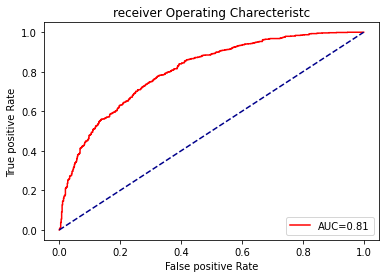

In [479]:
plot_ROC(roc_auc,fpr,tpr)

### Trial 3

In [480]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1) # changed the test size

In [481]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((9132, 88), (1015, 88), (9132,), (1015,))

In [482]:
rfc=RandomForestClassifier(n_estimators=550,min_samples_split=3) # not used max_depth=45

In [283]:
rfc.fit(X_train,y_train)

RandomForestClassifier(min_samples_split=3, n_estimators=550)

In [284]:
y_pred=rfc.predict(X_test)

In [285]:
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy_score(y_test,y_pred)

0.7596059113300493

In [286]:
prob = rfc.predict_proba(X_test)
prob

array([[0.47777273, 0.52222727],
       [0.31596104, 0.68403896],
       [0.75124242, 0.24875758],
       ...,
       [0.29942424, 0.70057576],
       [0.16470996, 0.83529004],
       [0.38809091, 0.61190909]])

In [287]:
prob_positive = prob[:,1]

In [288]:
fpr, tpr, threshold = roc_curve(y_test,prob_positive)

In [289]:
ftt = pd.DataFrame(np.hstack((threshold.reshape(-1,1),fpr.reshape(-1,1),tpr.reshape(-1,1))),columns = ['threshold','fpr','tpr'])
ftt

,threshold,fpr,tpr
0,1.967818,0.000000,0.000000
1,0.967818,0.000000,0.001610
2,0.937939,0.000000,0.017713
3,0.937818,0.002538,0.017713
4,0.925667,0.002538,0.033816
...,...,...,...
343,0.199636,0.852792,0.996779
344,0.198848,0.852792,0.998390
345,0.165848,0.926396,0.998390
346,0.163242,0.926396,1.000000


In [290]:
roc_auc = auc(fpr,tpr)
roc_auc

0.8216647457433156

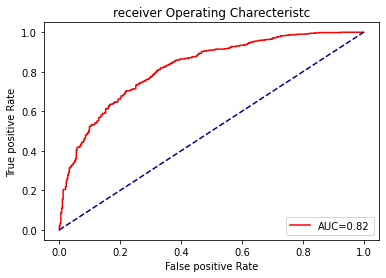

In [291]:
plot_ROC(roc_auc,fpr,tpr)

### Trial 4

In [292]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15) # changed the test size

In [293]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((8624, 88), (1523, 88), (8624,), (1523,))

In [294]:
rfc=RandomForestClassifier(n_estimators=550,min_samples_split=3)

In [295]:
rfc.fit(X_train,y_train)

RandomForestClassifier(min_samples_split=3, n_estimators=550)

In [296]:
y_pred=rfc.predict(X_test)

In [297]:
accuracy_score(y_test,y_pred)

0.7511490479317138

In [298]:
prob = rfc.predict_proba(X_test)
prob

array([[0.48334199, 0.51665801],
       [0.73775758, 0.26224242],
       [0.13645455, 0.86354545],
       ...,
       [0.7724632 , 0.2275368 ],
       [0.82851515, 0.17148485],
       [0.82248485, 0.17751515]])

In [299]:
prob_positive = prob[:,1]

In [300]:
fpr, tpr, threshold = roc_curve(y_test,prob_positive)

In [301]:
ftt = pd.DataFrame(np.hstack((threshold.reshape(-1,1),fpr.reshape(-1,1),tpr.reshape(-1,1))),columns = ['threshold','fpr','tpr'])
ftt

,threshold,fpr,tpr
0,1.975152,0.000000,0.000000
1,0.975152,0.000000,0.001115
2,0.880121,0.000000,0.073579
3,0.879091,0.001597,0.073579
4,0.865273,0.001597,0.094760
...,...,...,...
493,0.150662,0.932907,0.996656
494,0.149879,0.932907,0.997770
495,0.118424,0.971246,0.997770
496,0.116455,0.971246,1.000000


In [302]:
roc_auc = auc(fpr,tpr)
roc_auc

0.8224575350565071

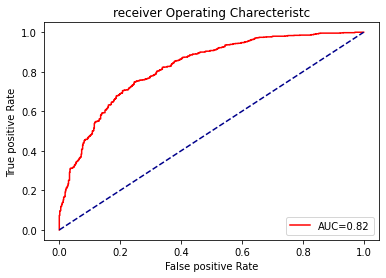

In [303]:
plot_ROC(roc_auc,fpr,tpr)

## Using CV :

In [305]:
from sklearn.model_selection import cross_validate,cross_val_score

In [306]:
scores=cross_val_score(estimator=rfc,X=X_train,y=y_train,cv=5)
scores  

array([0.74782609, 0.74782609, 0.74376812, 0.78086957, 0.76044084])

In [307]:
round(scores.mean(),2)  

0.76

# Logistic Regression:

### Trial 1

In [308]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) #, random_state=25,stratify=y

In [309]:
from sklearn.linear_model import LogisticRegression

In [310]:
logr = LogisticRegression()
logr.fit(X_train, y_train)

LogisticRegression()

In [311]:
y_pred = logr.predict(X_test)

In [312]:
accuracy_score(y_test, y_pred)

0.5847290640394088

# KNN Model : 

### Trial 1

In [313]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, random_state = 33,stratify=y)

In [314]:
from sklearn.neighbors import KNeighborsClassifier

In [315]:
knn = KNeighborsClassifier(n_neighbors=9) 

In [316]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=9)

In [317]:
y_pred = knn.predict(X_test)

In [318]:
accuracy_score(y_test, y_pred)

0.5971620023649981

In [319]:
scores=cross_val_score(estimator=knn,X=X_train,y=y_train,cv=5)
scores  

array([0.58409987, 0.59395532, 0.59001314, 0.60840999, 0.60775296])

In [320]:
knn = KNeighborsClassifier()
params = {'n_neighbors':list(range(1,11))}   # 'max_depth' it can be taken any range.
cv_model = GridSearchCV(estimator=knn,cv=5,param_grid = params,return_train_score=True)
cv_model.fit(X_train,y_train)
print(cv_model.best_params_)

{'n_neighbors': 1}


### Trial 2

In [321]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.15) #, random_state = 33,stratify=y

In [322]:
knn = KNeighborsClassifier(n_neighbors=9) 

In [323]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=9)

In [324]:
y_pred = knn.predict(X_test)

In [325]:
accuracy_score(y_test, y_pred)

0.5863427445830598

# SVM model :

### Trial 1

In [326]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.15) 

In [327]:
from sklearn.svm import SVC

In [328]:
clf = SVC()

In [329]:
clf.fit(X_train, y_train) 

SVC()

In [330]:
y_pred = clf.predict(X_test)

In [331]:
accuracy_score(y_test, y_pred)

0.5653315824031516

In [332]:
scores=cross_val_score(estimator=clf,X=X_train,y=y_train,cv=5)
scores  

array([0.56869565, 0.56869565, 0.56927536, 0.56927536, 0.56902552])

## Prediction using the test data:

### Trial 1

In [334]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [335]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((8624, 88), (1523, 88), (8624,), (1523,))

In [342]:
rfc_sf=RandomForestClassifier(n_estimators=550,min_samples_split=3)

In [343]:
rfc_sf.fit(X_train,y_train)

RandomForestClassifier(min_samples_split=3, n_estimators=550)

In [344]:
y_pred=rfc_sf.predict(X_test)

In [345]:
accuracy_score(y_test,y_pred)

0.7734734077478661

In [346]:
scores=cross_val_score(estimator=rfc_sf,X=X_train,y=y_train,cv=5)
scores  

array([0.74318841, 0.74376812, 0.74898551, 0.74782609, 0.75696056])

In [347]:
prob = rfc_sf.predict_proba(X_test)
prob

array([[0.50598485, 0.49401515],
       [0.17515152, 0.82484848],
       [0.46866667, 0.53133333],
       ...,
       [0.68727273, 0.31272727],
       [0.28093939, 0.71906061],
       [0.37469697, 0.62530303]])

In [348]:
prob_positive = prob[:,1]

In [349]:
fpr, tpr, threshold = roc_curve(y_test,prob_positive)

In [350]:
ftt = pd.DataFrame(np.hstack((threshold.reshape(-1,1),fpr.reshape(-1,1),tpr.reshape(-1,1))),columns = ['threshold','fpr','tpr'])
ftt

,threshold,fpr,tpr
0,1.972667,0.000000,0.000000
1,0.972667,0.000000,0.001121
2,0.953091,0.000000,0.013453
3,0.947848,0.001585,0.013453
4,0.903091,0.001585,0.054933
...,...,...,...
479,0.208030,0.860539,0.997758
480,0.206455,0.860539,0.998879
481,0.191727,0.885895,0.998879
482,0.191152,0.885895,1.000000


In [351]:
roc_auc = auc(fpr,tpr)
roc_auc

0.8387995423308435

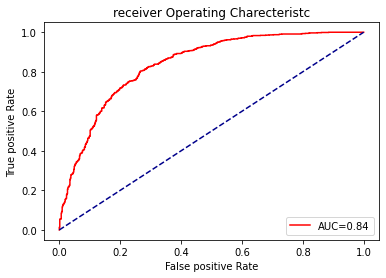

In [352]:
plot_ROC(roc_auc,fpr,tpr)

### Training for the actual data without splitting

In [483]:
rfc_final=RandomForestClassifier(n_estimators=550,min_samples_split=3)

In [484]:
rfc_final.fit(X,y)

RandomForestClassifier(min_samples_split=3, n_estimators=550)

In [485]:
y_pred=rfc_final.predict(X)

In [486]:
scores=cross_val_score(estimator=rfc_final,X=X,y=y,cv=5)
scores  

array([0.76059113, 0.77093596, 0.75751602, 0.75702316, 0.75357319])

In [489]:
result_df = pd.DataFrame({"customer_id":edai.idColumn, "Y":y_pred})
result_df.to_csv("Group8_08.csv", index=False)